## Import necessary libraries and packages

In [41]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import random
import re
from statistics import mean
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import f_oneway
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf
import seaborn as sns
import researchpy as rp

## Read in a pandas dataframe containing our image arrays along with some metadata

In [42]:
data = pd.read_pickle("/Volumes/onishlab_shared/PROJECTS/30_Andrew/03_IMAGING_DATABASE/IMDB.pkl")

data

,date,strain,feed,temp,name,stage,rating,comments,ID,array_vals,array_vals_ni,REP
0,230614,N2,JUB66_RFP,25,image1,YL4,4,comments,00021,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",1
1,230614,N2,JUB66_RFP,25,image2,YL4,4,comments,00022,"[0.010910200656137941, 0.01151731697290573, 0....","[0.010910200656137941, 0.011764705882352941, 0...",1
2,230614,N2,JUB66_RFP,25,image3,YL4,5,comments,00023,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",1
3,230614,N2,JUB66_RFP,25,image4,YL4,4,comments,00024,"[0.011444266422522316, 0.011697760685114819, 0...","[0.011444266422522316, 0.011764705882352941, 0...",1
4,230614,N2,JUB66_RFP,25,image5,YL4,4,Lots of signal in this one all concentrated n...,00025,"[0.011764705882352941, 0.014485120414898868, 0...","[0.011764705882352941, 0.015030136568245976, 0...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
85,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image6,L4,4,comments,00106,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3
86,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image7,YL4,4,comments,00107,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3
87,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image8,L4,3,comments,00108,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3
88,230721,N2,MK_JUB66_RFP_IN_JUB66,25,image9,L4,4,comments,00109,"[0.011764705882352941, 0.011764705882352941, 0...","[0.011764705882352941, 0.011764705882352941, 0...",3


## Load our image arrays into a useful form where we can work with it in numpy. Each image array is a 1D array with 3500 values. These 3500 values have been interpolated from our images of various lengths <3500. Each value in the array originally had a value between 0 and 4095 representing the raw signal from the microscope sensor. In this case, values below # were set to 0 to threshold out the gut granules. This threshold information can be found in the metadata of the dataframe. This threshold can of course be adjusted at the analysis step. After thresholding, values in the array are normalized by dividing each by 4095 so that each value is between 0 and 1. Using linear interpolation, all arrays are stretched to a standardized length of 3500 values.

In [44]:
# make an array of the thresholded data
arr_data = data["array_vals_ni"].values
arr_data

# make an array of the strain names
arr_values = data["feed"].values
arr_values

# make an dataframe of both the thresholded data and the strain names
df = pd.DataFrame({'arr_values':arr_values, 'arr_data':arr_data})
print(df)

               arr_values                                           arr_data
0               JUB66_RFP  [0.011764705882352941, 0.011764705882352941, 0...
1               JUB66_RFP  [0.010910200656137941, 0.011764705882352941, 0...
2               JUB66_RFP  [0.011764705882352941, 0.011764705882352941, 0...
3               JUB66_RFP  [0.011444266422522316, 0.011764705882352941, 0...
4               JUB66_RFP  [0.011764705882352941, 0.015030136568245976, 0...
..                    ...                                                ...
85  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...
86  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...
87  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...
88  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...
89  MK_JUB66_RFP_IN_JUB66  [0.011764705882352941, 0.011764705882352941, 0...

[90 rows x 2 columns]


## check to make sure the order isnt messed up

In [45]:
a = data['feed']
b = data['array_vals_ni']
c = pd.DataFrame({'arr_values':a, 'arr_data':b})

df == c

,arr_values,arr_data
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
85,True,True
86,True,True
87,True,True
88,True,True


## check how long the arrays are

In [46]:
arr_data = data["array_vals_ni"].values
arr_data[0].shape

(2457,)

## split samples into their respective groups

In [78]:
JUB66_RFP = df[df['arr_values'] == 'JUB66_RFP']
JUB66_RFP = JUB66_RFP['arr_data']
JUB66_RFP = np.array(JUB66_RFP)

JUB66_RFP_IN_CEMBIO = df[df['arr_values'] == 'JUB66_RFP_IN_CEMBIO']
JUB66_RFP_IN_CEMBIO = JUB66_RFP_IN_CEMBIO['arr_data']
JUB66_RFP_IN_CEMBIO = np.array(JUB66_RFP_IN_CEMBIO)

MK_JUB66_RFP = df[df['arr_values'] == 'MK_JUB66_RFP_IN_JUB66']
MK_JUB66_RFP = MK_JUB66_RFP['arr_data']
MK_JUB66_RFP = np.array(MK_JUB66_RFP)

## look at sample array lengths

In [86]:
for sample in JUB66_RFP:
  print(len(sample))

#for sample in JUB66_RFP_IN_CEMBIO:
#  print(len(sample))

#for sample in MK_JUB66_RFP:
#  print(len(sample))

2457
2487
2517
2769
2916
3168
3240
3264
2694
2874
2346
2973
2802
2952
2805
3092
2943
2805
2877
3057
2499
2634
2394
2469
2631
2781
2619
2667
2592
2556


## loop through each sample in JUB66_RFP and split the array into 3rds

In [99]:
new_array = []

# Loop through each sample in JUB66_RFP
for index, sample in enumerate(JUB66_RFP):
    for divisor in range(1, len(sample)):
        if len(sample) % divisor == 3:
            
            # Split the sample into three parts
            split_sample = np.array_split(sample, len(sample) % divisor)
    
            # Append the split sample along with the part label to the new array
            for part_index, part in enumerate(split_sample):
                part_label = f"Part {part_index+1} of Sample {index+1}"
                new_array.append((part_label, part))
            
            # Stop the loop at the first divisor that yields a remainder of 3
            break
                
JUB66_RFP_df = pd.DataFrame(new_array) 

JUB66_RFP_df.columns = ['ID', 'arr_data']

# Create a new column to store the row sums
JUB66_RFP_df['row_sum'] = 0

# Iterate through each sample in the dataframe
for index, row in JUB66_RFP_df.iterrows():
    # Calculate the sum of the array or row
    row_sum = sum(row['arr_data'])
    
    # Assign the row sum to the 'row_sum' column
    JUB66_RFP_df.at[index, 'row_sum'] = row_sum
    
# Print the updated dataframe
print(JUB66_RFP_df)

# New column values
new_column = np.repeat('JUB66_RFP', len(JUB66_RFP_df))
# Add a new column to the DataFrame
JUB66_RFP_df['diet'] = new_column

                     ID                                           arr_data   
0    Part 1 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...  \
1    Part 2 of Sample 1  [0.02583352407110704, 0.023529411764705882, 0....   
2    Part 3 of Sample 1  [0.026672770275425344, 0.019562066071564813, 0...   
3    Part 1 of Sample 2  [0.010910200656137941, 0.011764705882352941, 0...   
4    Part 2 of Sample 2  [0.013183794918745708, 0.011764705882352941, 0...   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
86  Part 3 of Sample 29  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011581597619592585, 0.011718928816662852, 0...   
89  Part 3 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   

      row_sum  
0   17.948775  
1   23.260716  
2   18.861952  

## loop through each sample in JUB66_RFP_IN_CEMBIO and split the array into 3rds

In [100]:
new_array = []

# Loop through each sample in JUB66_RFP_IN_CEMBIO
for index, sample in enumerate(JUB66_RFP_IN_CEMBIO):
    for divisor in range(1, len(sample)):
        if len(sample) % divisor == 3:
            
            # Split the sample into three parts
            split_sample = np.array_split(sample, len(sample) % divisor)
    
            # Append the split sample along with the part label to the new array
            for part_index, part in enumerate(split_sample):
                part_label = f"Part {part_index+1} of Sample {index+1}"
                new_array.append((part_label, part))     
            
            # Stop the loop at the first divisor that yields a remainder of 3
            break
        
JUB66_RFP_IN_CEMBIO_df = pd.DataFrame(new_array) 

JUB66_RFP_IN_CEMBIO_df.columns = ['ID', 'arr_data']

# Create a new column to store the row sums
JUB66_RFP_IN_CEMBIO_df['row_sum'] = 0

# Iterate through each sample in the dataframe
for index, row in JUB66_RFP_IN_CEMBIO_df.iterrows():
    # Calculate the sum of the array or row
    row_sum = sum(row['arr_data'])
    
    # Assign the row sum to the 'row_sum' column
    JUB66_RFP_IN_CEMBIO_df.at[index, 'row_sum'] = row_sum
    
# Print the updated dataframe
print(JUB66_RFP_IN_CEMBIO_df)

# New column values
new_column = np.repeat('JUB66_RFP_IN_CEMBIO', len(JUB66_RFP_IN_CEMBIO_df))
# Add a new column to the DataFrame
JUB66_RFP_IN_CEMBIO_df['diet'] = new_column

                     ID                                           arr_data   
0    Part 1 of Sample 1  [0.011764705882352941, 0.03221179522392614, 0....  \
1    Part 2 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...   
2    Part 3 of Sample 1  [0.014389257648584725, 0.017593652246890974, 0...   
3    Part 1 of Sample 2  [0.6690318150606546, 0.5569695582513161, 0.365...   
4    Part 2 of Sample 2  [0.01715114061188678, 0.017746242465857938, 0....   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.01568627450980392, 0.01568627450980392, 0.0...   
86  Part 3 of Sample 29  [0.013168535896849012, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.010589761196307317, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
89  Part 3 of Sample 30  [0.01568627450980392, 0.014404516670481423, 0....   

      row_sum  
0   21.141360  
1   12.073915  
2   12.856672  

## loop through each sample in MK_JUB66_RFP and split the array into 3rds

In [101]:
new_array = []

# Loop through each sample in MK_JUB66_RFP
for index, sample in enumerate(MK_JUB66_RFP):
    for divisor in range(1, len(sample)):
        if len(sample) % divisor == 3:
            
            # Split the sample into three parts
            split_sample = np.array_split(sample, len(sample) % divisor)
    
            # Append the split sample along with the part label to the new array
            for part_index, part in enumerate(split_sample):
                part_label = f"Part {part_index+1} of Sample {index+1}"
                new_array.append((part_label, part))     
            
            # Stop the loop at the first divisor that yields a remainder of 3
            break

MK_JUB66_RFP_df = pd.DataFrame(new_array) 

MK_JUB66_RFP_df.columns = ['ID', 'arr_data']

# Create a new column to store the row sums
MK_JUB66_RFP_df['row_sum'] = 0

# Iterate through each sample in the dataframe
for index, row in MK_JUB66_RFP_df.iterrows():
    # Calculate the sum of the array or row
    row_sum = sum(row['arr_data'])
    
    # Assign the row sum to the 'row_sum' column
    MK_JUB66_RFP_df.at[index, 'row_sum'] = row_sum
    
# Print the updated dataframe
print(MK_JUB66_RFP_df)

# New column values
new_column = np.repeat('MK_JUB66_RFP', len(MK_JUB66_RFP_df))
# Add a new column to the DataFrame
MK_JUB66_RFP_df['diet'] = new_column

                     ID                                           arr_data   
0    Part 1 of Sample 1  [0.01095597772182803, 0.014297703517204547, 0....  \
1    Part 2 of Sample 1  [0.02340733958953231, 0.020950637064164186, 0....   
2    Part 3 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...   
3    Part 1 of Sample 2  [0.011764705882352941, 0.011764705882352941, 0...   
4    Part 2 of Sample 2  [0.011154345006485085, 0.011764705882352941, 0...   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
86  Part 3 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
89  Part 3 of Sample 30  [0.01211566338597696, 0.01568627450980392, 0.0...   

      row_sum  
0   12.096284  
1   11.649348  
2   11.285985  

## Combine all the seperate DFs back into one

In [102]:
combined_df = pd.concat([JUB66_RFP_df, JUB66_RFP_IN_CEMBIO_df, MK_JUB66_RFP_df])
print(combined_df)

                     ID                                           arr_data   
0    Part 1 of Sample 1  [0.011764705882352941, 0.011764705882352941, 0...  \
1    Part 2 of Sample 1  [0.02583352407110704, 0.023529411764705882, 0....   
2    Part 3 of Sample 1  [0.026672770275425344, 0.019562066071564813, 0...   
3    Part 1 of Sample 2  [0.010910200656137941, 0.011764705882352941, 0...   
4    Part 2 of Sample 2  [0.013183794918745708, 0.011764705882352941, 0...   
..                  ...                                                ...   
85  Part 2 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
86  Part 3 of Sample 29  [0.011764705882352941, 0.011764705882352941, 0...   
87  Part 1 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
88  Part 2 of Sample 30  [0.011764705882352941, 0.011764705882352941, 0...   
89  Part 3 of Sample 30  [0.01211566338597696, 0.01568627450980392, 0.0...   

      row_sum          diet  
0   17.948775     JUB66_RFP  
1  

# Make a new column called 'part' to assign a region for each observation

In [104]:
seq = ['part 1', 'part 2', 'part 3']
repeat_seq = seq * 90 
#print(repeat_seq)
#len(repeat_seq)
combined_df = combined_df.assign(part=repeat_seq)
combined_df

,ID,arr_data,row_sum,diet,part
0,Part 1 of Sample 1,"[0.011764705882352941, 0.011764705882352941, 0...",17.948775,JUB66_RFP,part 1
1,Part 2 of Sample 1,"[0.02583352407110704, 0.023529411764705882, 0....",23.260716,JUB66_RFP,part 2
2,Part 3 of Sample 1,"[0.026672770275425344, 0.019562066071564813, 0...",18.861952,JUB66_RFP,part 3
3,Part 1 of Sample 2,"[0.010910200656137941, 0.011764705882352941, 0...",13.045731,JUB66_RFP,part 1
4,Part 2 of Sample 2,"[0.013183794918745708, 0.011764705882352941, 0...",14.105211,JUB66_RFP,part 2
...,...,...,...,...,...
85,Part 2 of Sample 29,"[0.011764705882352941, 0.011764705882352941, 0...",17.347829,MK_JUB66_RFP,part 2
86,Part 3 of Sample 29,"[0.011764705882352941, 0.011764705882352941, 0...",14.939513,MK_JUB66_RFP,part 3
87,Part 1 of Sample 30,"[0.011764705882352941, 0.011764705882352941, 0...",16.289174,MK_JUB66_RFP,part 1
88,Part 2 of Sample 30,"[0.011764705882352941, 0.011764705882352941, 0...",15.235981,MK_JUB66_RFP,part 2


-----

# Graph the data

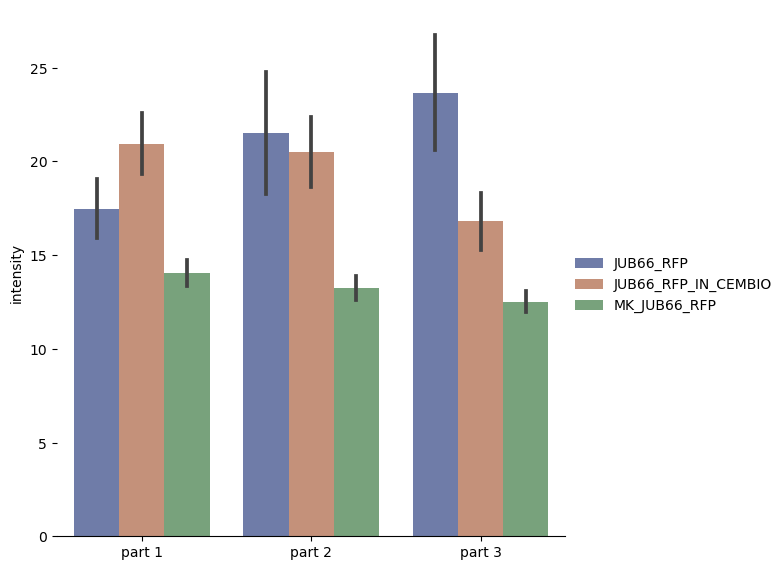

In [105]:
g = sns.catplot(
    data=combined_df, kind="bar",
    x="part", y="row_sum", hue="diet",
    errorbar="se", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "intensity")
g.legend.set_title("")

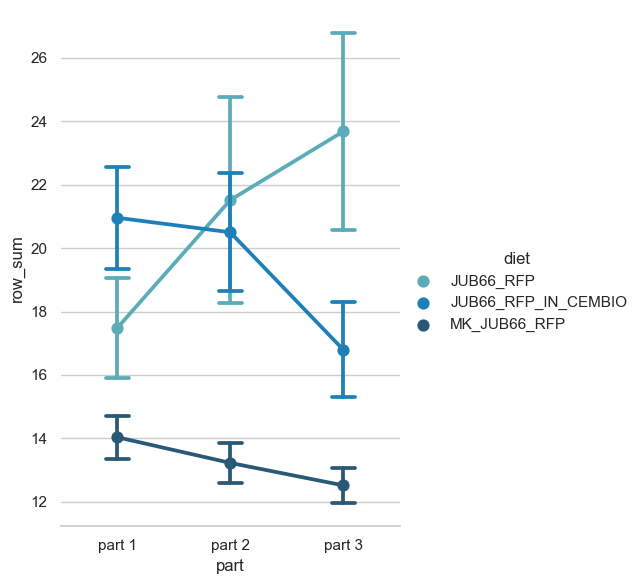

In [106]:
sns.set_theme(style="whitegrid")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=combined_df, x="part", y="row_sum", hue="diet",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

[Text(0, 0.5, '')]

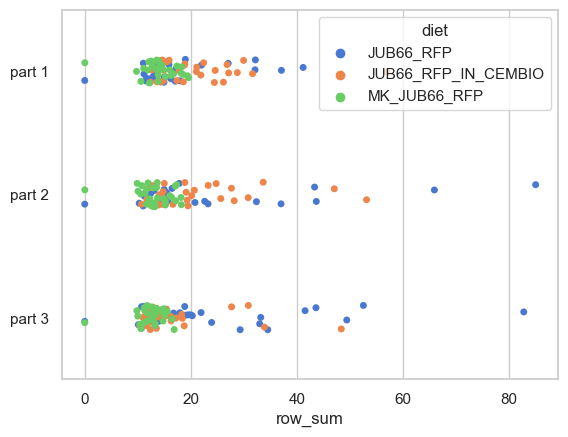

In [107]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
#ax = sns.swarmplot(data=combined_df, x="row_sum", y="part", hue="diet")
#ax.set(ylabel="")

ax = sns.stripplot(data=combined_df, x="row_sum", y="part", hue="diet")
ax.set(ylabel="")

<Axes: xlabel='part', ylabel='row_sum'>

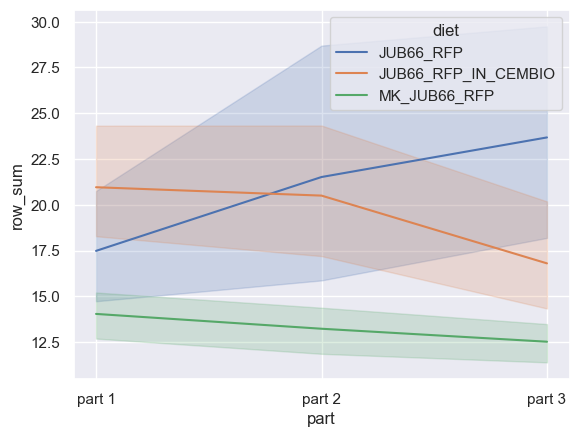

In [108]:
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="part", y="row_sum",
             hue="diet",
             data=combined_df)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, '(part 1, JUB66_RFP)'),
  Text(2, 0, '(part 1, JUB66_RFP_IN_CEMBIO)'),
  Text(3, 0, '(part 1, MK_JUB66_RFP)'),
  Text(4, 0, '(part 2, JUB66_RFP)'),
  Text(5, 0, '(part 2, JUB66_RFP_IN_CEMBIO)'),
  Text(6, 0, '(part 2, MK_JUB66_RFP)'),
  Text(7, 0, '(part 3, JUB66_RFP)'),
  Text(8, 0, '(part 3, JUB66_RFP_IN_CEMBIO)'),
  Text(9, 0, '(part 3, MK_JUB66_RFP)')])

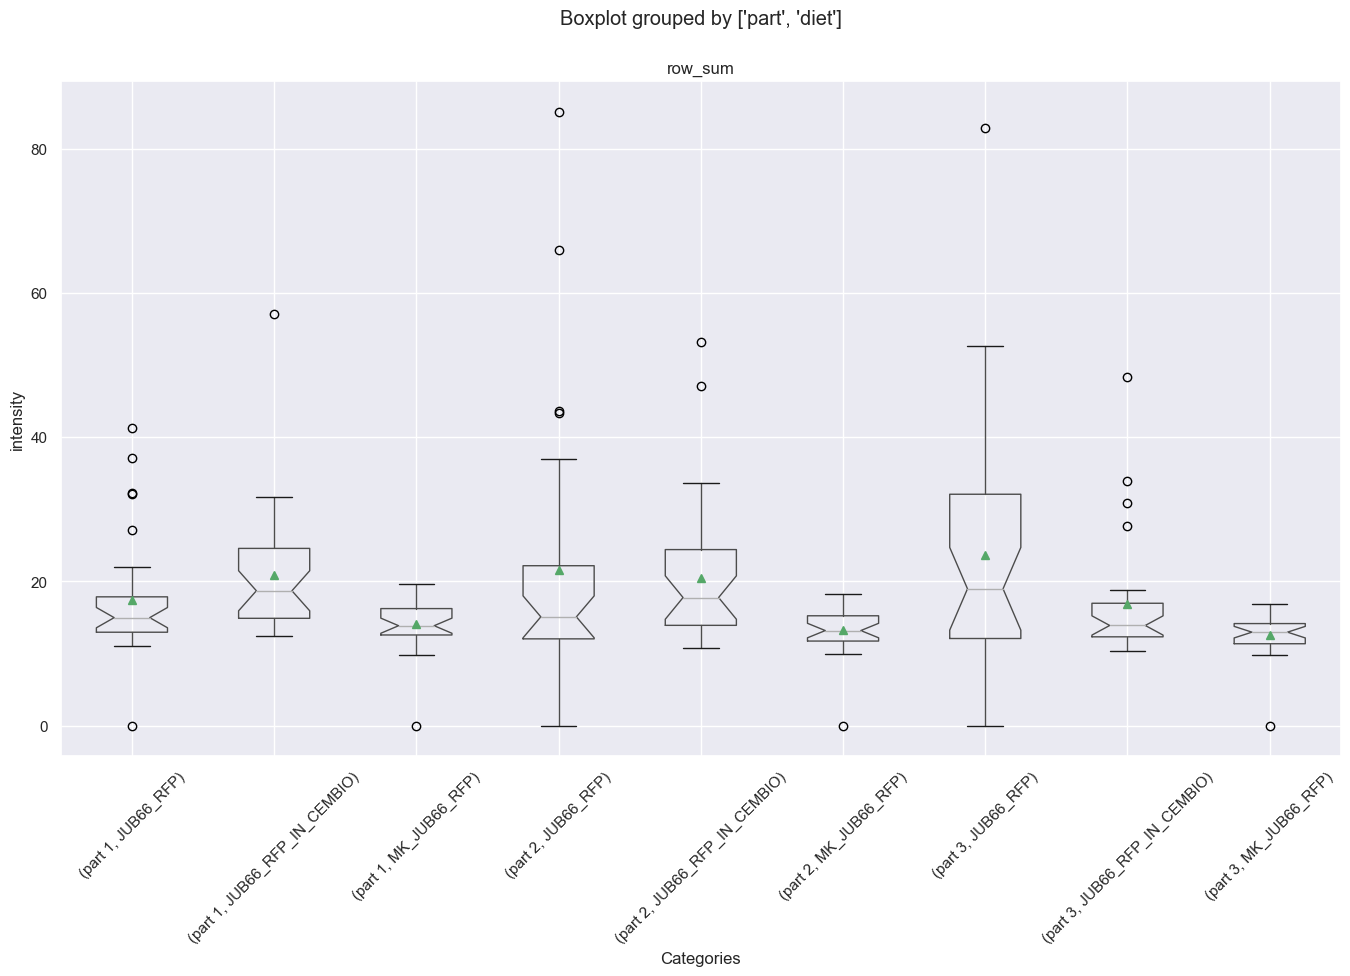

In [109]:
boxplot = combined_df.boxplot(["row_sum"], by = ["part", "diet"],
                     figsize = (16, 9),
                     showmeans = True,
                     notch = True)

boxplot.set_xlabel("Categories")
boxplot.set_ylabel("intensity")
plt.xticks(rotation=45)

------

## Linear mixed effects model

In [110]:
# lets look at the row_sum based on their diet and the part grouping.
rp.summary_cont(combined_df.groupby(["diet", "part"])["row_sum"])

N     Mean       SD      SE  95% Conf.  Interval
diet                part                                                     
JUB66_RFP           part 1  30  17.4806   8.5553  1.5620    14.2860   20.6752
                    part 2  30  21.5130  17.7734  3.2450    14.8763   28.1497
                    part 3  30  23.6749  16.9218  3.0895    17.3562   29.9936
JUB66_RFP_IN_CEMBIO part 1  30  20.9553   8.8039  1.6074    17.6678   24.2427
                    part 2  30  20.4982  10.1482  1.8528    16.7088   24.2876
                    part 3  30  16.7985   8.2169  1.5002    13.7303   19.8668
MK_JUB66_RFP        part 1  30  14.0384   3.7108  0.6775    12.6527   15.4240
                    part 2  30  13.2290   3.4601  0.6317    11.9369   14.5210
                    part 3  30  12.5210   2.9956  0.5469    11.4024   13.6396

In [111]:
# In a mixed effects model, you have two types of variables: fixed effects and random effects. Fixed effects represent variables that you are specifically interested in and want to estimate the effect size for. Random effects, on the other hand, capture the variability or correlation within certain grouping levels that you want to account for.

model = smf.mixedlm("row_sum ~ C(diet) + C(part) + C(diet):C(part)", combined_df, groups = "ID").fit()
model.summary()

# The "groups" parameter being set to "part" indicates that you want to account for the correlation within each level of the "part" variable. Thus, it is specified as the grouping variable for the random effects. 
# This suggests that your data has multiple measurements or observations nested within different "part" levels. By including "part" as a random effect, you are modeling the correlation or dependence among observations within the same "part" group. This acknowledges that observations within the same "part" may be more similar to each other than observations from different "part" groups.
# By accounting for the correlation within each level of the "part" variable, the mixed effects model allows for more accurate estimation of the fixed effects and provides more reliable inference. It helps to handle the potential correlation structure in the data and can provide better predictions or interpretations.

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM             Dependent Variable:             row_sum  
No. Observations:               270                 Method:                         REML     
No. Groups:                     90                  Scale:                          97.2510  
Min. group size:                3                   Log-Likelihood:                 -993.8648
Max. group size:                3                   Converged:                      Yes      
Mean group size:                3.0                                                          
---------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                         17.481    1.884  9.279 0.000  13.788 21.173
C(diet)[T.JUB66_RFP_IN_CEMBIO]                     3.475    2.546  1.365 0.172  -1.516  8.465
C(diet)[T.MK_JUB66_RFP]                           -3.442    2.546 -1.352 0.176  -8.433  1.548
C(part)[T.part 2]                                  4.032    2.664  1.514 0.130  -1.189  9.254
C(part)[T.part 3]                                  6.194    2.664  2.325 0.020   0.973 11.416
C(diet)[T.JUB66_RFP_IN_CEMBIO]:C(part)[T.part 2]  -4.489    3.601 -1.247 0.212 -11.547  2.568
C(diet)[T.MK_JUB66_RFP]:C(part)[T.part 2]         -4.842    3.601 -1.345 0.179 -11.899  2.216
C(diet)[T.JUB66_RFP_IN_CEMBIO]:C(part)[T.part 3] -10.351    3.601 -2.875 0.004 -17.409 -3.293
C(diet)[T.MK_JUB66_RFP]:C(part)[T.part 3]         -7.712    3.601 -2.142 0.032 -14.769 -0.654
ID Var                                             9.212    0.784                            
=============================================================================================

"""

------

## Kolmogorov-Smirnov (KS) test for goodness of fit (non-parametric test)

**Purpose:** test for differences in the shape of 2 sample distributions (or to compare to expected statistical distribution). Compares the overall shape of distributions.

**Type of data:** univariate, continous data 

H0: Two samples drawn from populations with the same distribution

**What it does:** test statistic D is the maximum absolute difference between the 2 comuluative distribution functions 

In [115]:
# need to use a version of the data prior to the arrays being split into thirds becuase the arrays dont split evenly

JUB66_RFP_org = df[df['arr_values'] == 'JUB66_RFP']
JUB66_RFP_org = JUB66_RFP_org['arr_data']
JUB66_RFP_org = np.array(JUB66_RFP_org)

JUB66_RFP_IN_CEMBIO_org = df[df['arr_values'] == 'JUB66_RFP_IN_CEMBIO']
JUB66_RFP_IN_CEMBIO_org = JUB66_RFP_IN_CEMBIO_org['arr_data']
JUB66_RFP_IN_CEMBIO_org = np.array(JUB66_RFP_IN_CEMBIO_org)

MK_JUB66_RFP_org = df[df['arr_values'] == 'MK_JUB66_RFP_IN_JUB66']
MK_JUB66_RFP_org = MK_JUB66_RFP_org['arr_data']
MK_JUB66_RFP_org = np.array(MK_JUB66_RFP_org)

#print(MK_JUB66_RFP_org)

#for sample in MK_JUB66_RFP_org:
#  print(len(sample))

In [131]:
# use for raw data with variable array lengths

def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [132]:
JUB66_RFP_avg = tolerant_mean(JUB66_RFP_org)
JUB66_RFP_IN_CEMBIO_avg = tolerant_mean(JUB66_RFP_IN_CEMBIO_org)
MK_JUB66_RFP_avg = tolerant_mean(MK_JUB66_RFP_org)

print(JUB66_RFP_avg)
print(JUB66_RFP_IN_CEMBIO_avg)
print(MK_JUB66_RFP_avg)

(masked_array(data=[0.016362757813890797, 0.02214643574680196,
                   0.02280003051804379, ..., 0.011764705882352941,
                   0.011306935225452048, 0.011764705882352941],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20), masked_array(data=[0.012072240425544566, 0.02990313327661444,
                   0.02847453838301903, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20))
(masked_array(data=[0.03363647923501436, 0.030707255664911868,
                   0.029844612293685298, ..., 0.011764705882352941,
                   0.011764705882352941, 0.011764705882352941],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20), masked_array(data=[0.11802492189484176, 0.09782809186538578,
                   0.0696150699312551, ..., 0.0, 0.0, 0.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+

In [116]:
# can also average all the samples within a group together and then compare the group averages with the KS test
JUB66_RFP_avg = np.mean(JUB66_RFP_org, axis=0)
JUB66_RFP_IN_CEMBIO_avg = np.mean(JUB66_RFP_IN_CEMBIO_org, axis=0)
MK_JUB66_RFP_avg = np.mean(MK_JUB66_RFP_org, axis=0)

print(JUB66_RFP_avg)
print(JUB66_RFP_IN_CEMBIO_avg)
print(MK_JUB66_RFP_avg)

ValueError: operands could not be broadcast together with shapes (2457,) (2487,) 

In [127]:
# import the 2 sample KS test
from scipy.stats import ks_2samp

In [128]:
ks_2samp(JUB66_RFP_avg, JUB66_RFP_IN_CEMBIO_avg)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3264 and the array at index 1 has size 3416

In [129]:
ks_2samp(JUB66_RFP_avg, MK_JUB66_RFP_avg)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3264 and the array at index 1 has size 3384

In [130]:
ks_2samp(JUB66_RFP_IN_CEMBIO_avg, MK_JUB66_RFP_avg)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3416 and the array at index 1 has size 3384

----

## Chi Square test for goodness of fit (non-parametric test)

In [203]:
# seperate data into groups based on diet and then by part

JUB66_RFP = combined_df[combined_df['diet'] == 'JUB66_RFP']
JUB66_RFP_part1 = JUB66_RFP[JUB66_RFP['part'] == 'part 1']
JUB66_RFP_part2 = JUB66_RFP[JUB66_RFP['part'] == 'part 2']
JUB66_RFP_part3 = JUB66_RFP[JUB66_RFP['part'] == 'part 3']

JUB66_RFP_part1 = JUB66_RFP_part1['arr_data']
JUB66_RFP_part2 = JUB66_RFP_part2['arr_data']
JUB66_RFP_part3 = JUB66_RFP_part3['arr_data']


JUB66_RFP_part1_avg = np.mean(JUB66_RFP_part1, axis=0)
JUB66_RFP_part2_avg = np.mean(JUB66_RFP_part2, axis=0)
JUB66_RFP_part3_avg = np.mean(JUB66_RFP_part3, axis=0)

print(JUB66_RFP_part3_avg)
len(JUB66_RFP_part3_avg)

[0.06170544 0.06067251 0.06100886 ... 0.03201834 0.03158331 0.03202166]


1166

In [202]:
JUB66_RFP_IN_CEMBIO = combined_df[combined_df['diet'] == 'JUB66_RFP_IN_CEMBIO']
JUB66_RFP_IN_CEMBIO_part1 = JUB66_RFP_IN_CEMBIO[JUB66_RFP_IN_CEMBIO['part'] == 'part 1']
JUB66_RFP_IN_CEMBIO_part2 = JUB66_RFP_IN_CEMBIO[JUB66_RFP_IN_CEMBIO['part'] == 'part 2']
JUB66_RFP_IN_CEMBIO_part3 = JUB66_RFP_IN_CEMBIO[JUB66_RFP_IN_CEMBIO['part'] == 'part 3']

JUB66_RFP_IN_CEMBIO_part1 = JUB66_RFP_IN_CEMBIO_part1['arr_data']
JUB66_RFP_IN_CEMBIO_part2 = JUB66_RFP_IN_CEMBIO_part2['arr_data']
JUB66_RFP_IN_CEMBIO_part3 = JUB66_RFP_IN_CEMBIO_part3['arr_data']


JUB66_RFP_IN_CEMBIO_part1_avg = np.mean(JUB66_RFP_IN_CEMBIO_part1, axis=0)
JUB66_RFP_IN_CEMBIO_part2_avg = np.mean(JUB66_RFP_IN_CEMBIO_part2, axis=0)
JUB66_RFP_IN_CEMBIO_part3_avg = np.mean(JUB66_RFP_IN_CEMBIO_part3, axis=0)

print(JUB66_RFP_IN_CEMBIO_part3_avg)
len(JUB66_RFP_IN_CEMBIO_part3_avg)

[0.01797761 0.01749451 0.0176671  ... 0.01334816 0.01300262 0.0126627 ]


1166

In [201]:
MK_JUB66_RFP = combined_df[combined_df['diet'] == 'MK_JUB66_RFP']
MK_JUB66_RFP_part1 = MK_JUB66_RFP[MK_JUB66_RFP['part'] == 'part 1']
MK_JUB66_RFP_part2 = MK_JUB66_RFP[MK_JUB66_RFP['part'] == 'part 2']
MK_JUB66_RFP_part3 = MK_JUB66_RFP[MK_JUB66_RFP['part'] == 'part 3']

MK_JUB66_RFP_part1 = MK_JUB66_RFP_part1['arr_data']
MK_JUB66_RFP_part2 = MK_JUB66_RFP_part2['arr_data']
MK_JUB66_RFP_part3 = MK_JUB66_RFP_part3['arr_data']


MK_JUB66_RFP_part1_avg = np.mean(MK_JUB66_RFP_part1, axis=0)
MK_JUB66_RFP_part2_avg = np.mean(MK_JUB66_RFP_part2, axis=0)
MK_JUB66_RFP_part3_avg = np.mean(MK_JUB66_RFP_part3, axis=0)

print(MK_JUB66_RFP_part3_avg)
len(MK_JUB66_RFP_part3_avg)

[0.01277387 0.01268829 0.01257297 ... 0.01155102 0.01142269 0.0111888 ]


1166

In [199]:
bootstrap_sample = np.random.choice(JUB66_RFP_part1_avg, size=len(JUB66_RFP_part1_avg), replace=True)

In [200]:
# Chi-Square Goodness of Fit Test
chi_square_test_statistic, p_value = stats.chisquare(JUB66_RFP_part1_avg, bootstrap_sample)
#chi_square_test_statistic, p_value = stats.chisquare(JUB66_RFP_part1_avg, JUB66_RFP_part2_avg, JUB66_RFP_part3_avg)
#chi_square_test_statistic, p_value = stats.chisquare(JUB66_RFP_part1_avg, JUB66_RFP_IN_CEMBIO_part1_avg, MK_JUB66_RFP_part1_avg)

# chi square test statistic and p value
print('chi_square_test_statistic is : ' + str(chi_square_test_statistic))
print('p_value : ' + str(p_value))

# find Chi-Square critical value
print(stats.chi2.ppf(1-0.05, df=6))

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.006297328354312978

rather than part 1, part 2, part 3
percentage into the worm, say like 10% into the worm is associated with int1-5 

---

In [ ]:
#logistic regression

#use the mk_jub66 as the experimental control